## Overview
In this notebook, we attempt to decompose the MNIST dataset into its PCA components and see how a trained neutral model perform with a reduced (in terms of dimensionality) test MNIST dataset and plot a graph of N-best PCA component vs testing accuracy. After that, we train a neutral model using the 100 and 20-best PCA components and test the model again.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

from scipy import linalg

#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch

#Useful for debugging problems
print(tf.__version__)

2.15.0


## Task 1
Train a neural network on the MNIST training dataset that achieves acceptable performance on the test dataset (>95% accuracy).


In [2]:
# We have done this in Coursework C so I will take the code from there.

## Load the MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

# normalise the image's pixel

train_images=train_images/255.0
test_images=test_images/255.0

# Design a new multi-convolution neutral network

model = keras.Sequential([
    keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu', input_shape=(28,28,1),padding='same'),
    keras.layers.AveragePooling2D(pool_size=(3,3),padding='same'),
    keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'),
    keras.layers.AveragePooling2D(pool_size=(3,3),padding='same'),
    keras.layers.Flatten(),
    keras.layers.Dense(30,activation='relu'),
    keras.layers.Dense(10,activation='softmax')
])

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.SGD(lr=1.0),
              metrics=['accuracy'])
model.summary()

history=model.fit(train_images, train_labels,batch_size=128, epochs=30)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 average_pooling2d (Average  (None, 10, 10, 32)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 average_pooling2d_1 (Avera  (None, 4, 4, 64)          0         
 gePooling2D)                                                    
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 30)                3

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


469/469 [==============================] - 38s 78ms/step - loss: 2.2854 - accuracy: 0.2436
Epoch 2/30
469/469 [==============================] - 30s 64ms/step - loss: 2.1557 - accuracy: 0.3636
Epoch 3/30
469/469 [==============================] - 30s 65ms/step - loss: 1.3220 - accuracy: 0.6531
Epoch 4/30
469/469 [==============================] - 32s 68ms/step - loss: 0.7030 - accuracy: 0.7881
Epoch 5/30
469/469 [==============================] - 30s 64ms/step - loss: 0.5669 - accuracy: 0.8282
Epoch 6/30
469/469 [==============================] - 33s 71ms/step - loss: 0.4873 - accuracy: 0.8533
Epoch 7/30
469/469 [==============================] - 33s 71ms/step - loss: 0.4294 - accuracy: 0.8699
Epoch 8/30
469/469 [==============================] - 35s 75ms/step - loss: 0.3855 - accuracy: 0.8838
Epoch 9/30
469/469 [==============================] - 37s 79ms/step - loss: 0.3512 - accuracy: 0.8941
Epoch 10/30
469/469 [==============================] - 36s 77ms/step - loss: 0.3220 - accurac

## Result for Task 1


In [3]:
test_loss,test_acc=model.evaluate(test_images,test_labels,verbose=2)
print("The accuracy of the trained model is ", test_acc *100, "%" )
print(test_images.shape)
print(test_labels.shape)

313/313 - 2s - loss: 0.1257 - accuracy: 0.9637 - 2s/epoch - 8ms/step
The accuracy of the trained model is  96.3699996471405 %
(10000, 28, 28)
(10000,)


# Task 2
Decompose the MNIST training dataset into its PCA components

In [10]:
print("train_images.shape: ",np.shape(train_images))
X=np.reshape(train_images,(60000,784))
print("X.shape:",np.shape(X))
mu=np.mean(X,axis=0)
x=X-mu
#rho=np.dot(np.transpose(x),x)  #Make the covaraince matrix by hand
rho=np.cov(x,rowvar=False) # Make the covaraince matrix by np.cov
print("rho.shape:",np.shape(rho))

#Get the eigenvalues and vectors
vals,vecs=linalg.eigh(rho)
#vals is a 1-D array of the eigenvalues in ascending order, vecs is a columnwise array of the normalised
# eigenvectors such that vecs[:,i] is the eigenvector correspondong to vals[i]
print("vecs.shape:",np.shape(vecs))
print("vals.shape:",np.shape(vals))
vecs=np.flip(vecs)
vals=np.flip(vals)



train_images.shape:  (60000, 28, 28)
X.shape: (60000, 784)
rho.shape: (784, 784)
vecs.shape: (784, 784)
vals.shape: (784,)


## Comment
The vecs,vals variables are the eigenvectors and eigenvalues of the covariance which determines the direction and magnitude of the new reduced space and it is the PCA components.

# Task 3
Use the N-best PCA components to make a new testing dataset (using the 10,000 MNIST test images) and make a plot of N vs testing accuracy using the neural network trained in 1) *WITOUT RETRAINING THE NETWORK*

## Mathematic to construct the N-best PCA components
y is the reduced dimensional variable, v is the eigenvector of the covariance and x is the non-reduced dimensional variable.
$$ P = x v $$
$$ y = P v^T $$



In [116]:
# the N component goes from 0 to 784
N=784

# Decomposing the MNIST testing dataset into PCA component
X_test=np.reshape(test_images,(10000,784))
mu_test=np.mean(X_test,axis=0)
x_test=X_test-mu_test             #ensure zero mean
rho_test=np.cov(x_test,rowvar=False)    #cavariance for the 10,000 test images
vals_test,vecs_test=linalg.eigh(rho_test)
P_test=np.dot(x_test,vecs_test[:])

#creating storage for accuracy corresponding to each Nth PCA component

step=20

N_test_accuracy=np.zeros(N)

for i in range(0,N,step):

        newImageN=(np.dot(P_test[:,0:i],vecs_test.T[0:i,:]))+mu_test

        test_data_N = np.reshape(newImageN,[10000,28,28])
        test_loss,test_acc= model.evaluate(test_data_N,test_labels,verbose=2)

        N_test_accuracy[i]=test_acc #store accuracy

N_accuracy=N_test_accuracy[0:N:step]



313/313 - 3s - loss: 8.3895 - accuracy: 0.0974 - 3s/epoch - 9ms/step
313/313 - 2s - loss: 8.3895 - accuracy: 0.0974 - 2s/epoch - 7ms/step
313/313 - 2s - loss: 8.3895 - accuracy: 0.0974 - 2s/epoch - 7ms/step
313/313 - 3s - loss: 8.3895 - accuracy: 0.0974 - 3s/epoch - 10ms/step
313/313 - 2s - loss: 8.3895 - accuracy: 0.0974 - 2s/epoch - 7ms/step
313/313 - 2s - loss: 8.3895 - accuracy: 0.0974 - 2s/epoch - 7ms/step
313/313 - 2s - loss: 8.3895 - accuracy: 0.0974 - 2s/epoch - 7ms/step
313/313 - 2s - loss: 8.3895 - accuracy: 0.0974 - 2s/epoch - 7ms/step
313/313 - 3s - loss: 8.3895 - accuracy: 0.0974 - 3s/epoch - 9ms/step
313/313 - 2s - loss: 8.3894 - accuracy: 0.0974 - 2s/epoch - 7ms/step
313/313 - 2s - loss: 8.3892 - accuracy: 0.0974 - 2s/epoch - 7ms/step
313/313 - 2s - loss: 8.3888 - accuracy: 0.0974 - 2s/epoch - 7ms/step
313/313 - 3s - loss: 8.3885 - accuracy: 0.0974 - 3s/epoch - 10ms/step
313/313 - 2s - loss: 8.3874 - accuracy: 0.0974 - 2s/epoch - 7ms/step
313/313 - 2s - loss: 8.3868 - ac

## Additional step to get a more accurate plot
We need to also compute the accuracy for the nearly *non*-reduced image and add it to the N_accuracy array for the full complete detailed plot

In [83]:
N_ending = np.array([781,782,783,784])

N_accuracy_ending=np.zeros(784)

for i in N_ending:
    newImageN=(np.dot(P_test[:,0:i],vecs_test.T[0:i,:]))+mu_test

    test_data_N = np.reshape(newImageN,[10000,28,28])
    test_loss,test_acc= model.evaluate(test_data_N,test_labels,verbose=2)

    N_accuracy_ending[i-1]=test_acc #store accuracy

# the accuracy near the non-reduced image
N_acc_ending=N_accuracy_ending[-4:]

313/313 - 3s - loss: 2.5488 - accuracy: 0.5220 - 3s/epoch - 9ms/step
313/313 - 3s - loss: 2.1285 - accuracy: 0.6105 - 3s/epoch - 9ms/step
313/313 - 3s - loss: 1.2007 - accuracy: 0.8042 - 3s/epoch - 8ms/step
313/313 - 3s - loss: 0.1257 - accuracy: 0.9637 - 3s/epoch - 9ms/step


## Plot of N vs testing accuracy

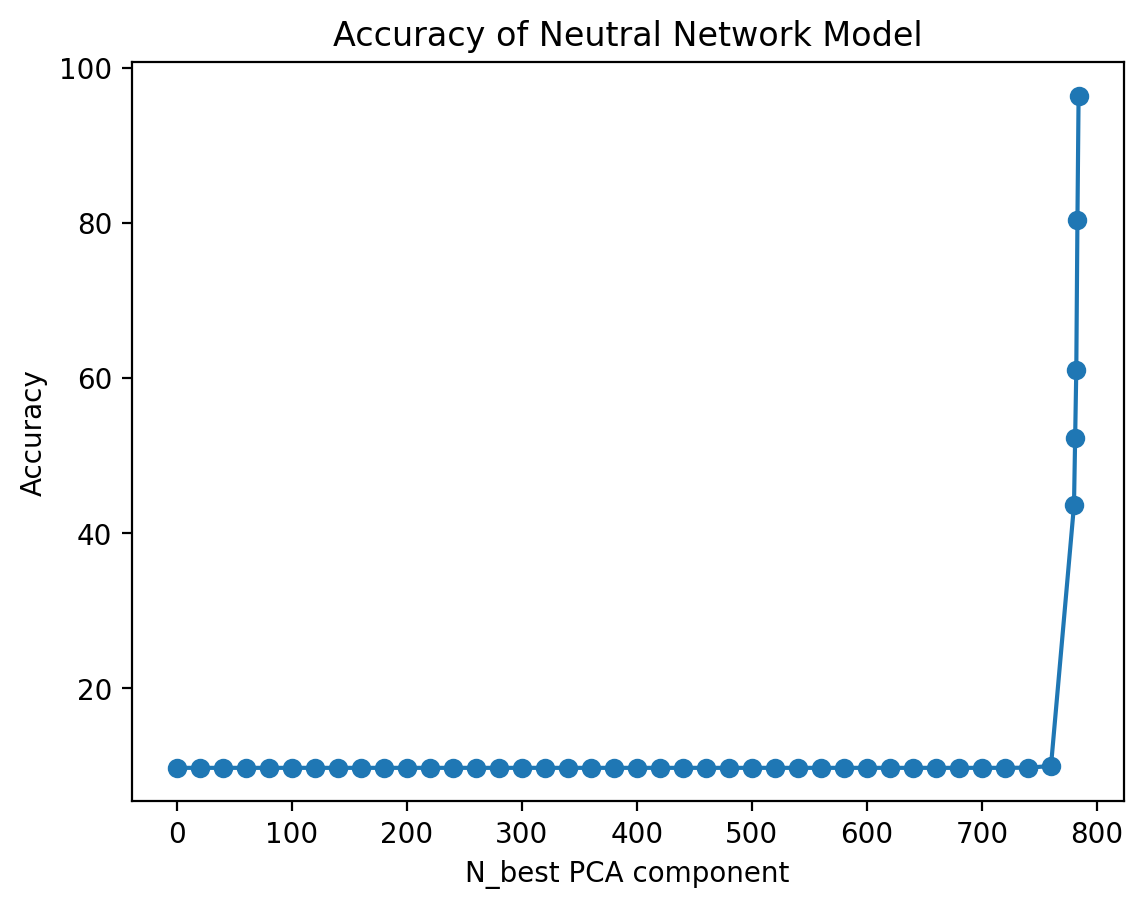

In [94]:

#merge the accuracy
Final_N_accuracy = ( np.concatenate((N_accuracy,N_acc_ending), axis=0) ) *100

#merge the N
N_x= np.concatenate((np.arange(0,784,20),N_ending),axis=0)

fig,ax=plt.subplots()
ax.plot(N_x,Final_N_accuracy,marker='o')
ax.set_xlabel('N_best PCA component')
ax.set_ylabel('Accuracy')
ax.title.set_text('Accuracy of Neutral Network Model')


### Result
The accuracy is very low for low number of N which is to be expected as the image has been reduced to a much lower dimensionality and the neutral network model is trained only with higher dimensionality training images. But we are able to fully recover the dimensionality of the testing image when N=784 by which the model have the same accuracy as when tested with the MNIST test image.
Therefore, we can conclude that the convolutional neutral network perform very badly when we reduce the dimensionality of the test image.

## Task 4
Now using the 100-best PCA components make a new training dataset (using the 60,000 MNIST training images) and retrain your neural network from 1)

In [118]:
# New training with new dataset from 100-best PCA component

P_train=np.dot(x,vecs)       #we have already decompose the train image into PCA component in Task 1


newImage100=(np.dot(P_train[:,0:100],vecs.T[0:100,:]))+mu    #new training dataset which undergo dimension-reduction


# transform the dataset from (60000,784) to (60000,28,28)
new_training_dataset=np.flipud(np.reshape(newImage100[:,:],[60000,28,28]))

print(new_training_dataset.shape)

(60000, 28, 28)


### Training model with new training dataset
retrain with new Image100 dataset

In [99]:

model2 = keras.Sequential([
    keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu', input_shape=(28,28,1),padding='same'),
    keras.layers.AveragePooling2D(pool_size=(3,3),padding='same'),
    keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'),
    keras.layers.AveragePooling2D(pool_size=(3,3),padding='same'),
    keras.layers.Flatten(),
    keras.layers.Dense(30,activation='relu'),
    keras.layers.Dense(10,activation='softmax')
])

model2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.SGD(lr=1.0),
              metrics=['accuracy'])
model2.summary()

history2=model2.fit(new_training_dataset, train_labels,batch_size=128, epochs=30)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 average_pooling2d_2 (Avera  (None, 10, 10, 32)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 average_pooling2d_3 (Avera  (None, 4, 4, 64)          0         
 gePooling2D)                                                    
                                                                 
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 30)               

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


469/469 [==============================] - 31s 65ms/step - loss: 2.3018 - accuracy: 0.1109
Epoch 2/30
469/469 [==============================] - 36s 78ms/step - loss: 2.3013 - accuracy: 0.1124
Epoch 3/30
469/469 [==============================] - 33s 70ms/step - loss: 2.3012 - accuracy: 0.1124
Epoch 4/30
469/469 [==============================] - 36s 77ms/step - loss: 2.3012 - accuracy: 0.1124
Epoch 5/30
469/469 [==============================] - 40s 86ms/step - loss: 2.3012 - accuracy: 0.1124
Epoch 6/30
469/469 [==============================] - 34s 72ms/step - loss: 2.3012 - accuracy: 0.1124
Epoch 7/30
469/469 [==============================] - 42s 90ms/step - loss: 2.3012 - accuracy: 0.1124
Epoch 8/30
469/469 [==============================] - 32s 69ms/step - loss: 2.3012 - accuracy: 0.1124
Epoch 9/30
469/469 [==============================] - 38s 82ms/step - loss: 2.3012 - accuracy: 0.1124
Epoch 10/30
469/469 [==============================] - 47s 101ms/step - loss: 2.3012 - accura

## Comment
The performance of the model is ~11.24% which is not great. This is expected as we have reduced the dimension of the image hence the model would be less accuracy at recognising the MNIST training data. Therefore, we would expect the performance of the model under the dimensionality-reduced test image to perform at best with an accuracy oof ~11.24%

## Task 5
Repeat step 3 using your new neural network from 4

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


313/313 - 2s - loss: 2.3010 - accuracy: 0.1135 - 2s/epoch - 7ms/step
313/313 - 2s - loss: 2.3010 - accuracy: 0.1135 - 2s/epoch - 7ms/step
313/313 - 2s - loss: 2.3010 - accuracy: 0.1135 - 2s/epoch - 7ms/step
313/313 - 3s - loss: 2.3010 - accuracy: 0.1135 - 3s/epoch - 10ms/step
313/313 - 2s - loss: 2.3010 - accuracy: 0.1135 - 2s/epoch - 7ms/step
313/313 - 2s - loss: 2.3010 - accuracy: 0.1135 - 2s/epoch - 7ms/step
313/313 - 2s - loss: 2.3010 - accuracy: 0.1135 - 2s/epoch - 7ms/step
313/313 - 3s - loss: 2.3010 - accuracy: 0.1135 - 3s/epoch - 9ms/step
313/313 - 2s - loss: 2.3010 - accuracy: 0.1135 - 2s/epoch - 7ms/step
313/313 - 2s - loss: 2.3010 - accuracy: 0.1135 - 2s/epoch - 7ms/step
313/313 - 2s - loss: 2.3010 - accuracy: 0.1135 - 2s/epoch - 7ms/step
313/313 - 3s - loss: 2.3010 - accuracy: 0.1135 - 3s/epoch - 9ms/step
313/313 - 2s - loss: 2.3010 - accuracy: 0.1135 - 2s/epoch - 7ms/step
313/313 - 2s - loss: 2.3010 - accuracy: 0.1135 - 2s/epoch - 7ms/step
313/313 - 3s - loss: 2.3010 - acc

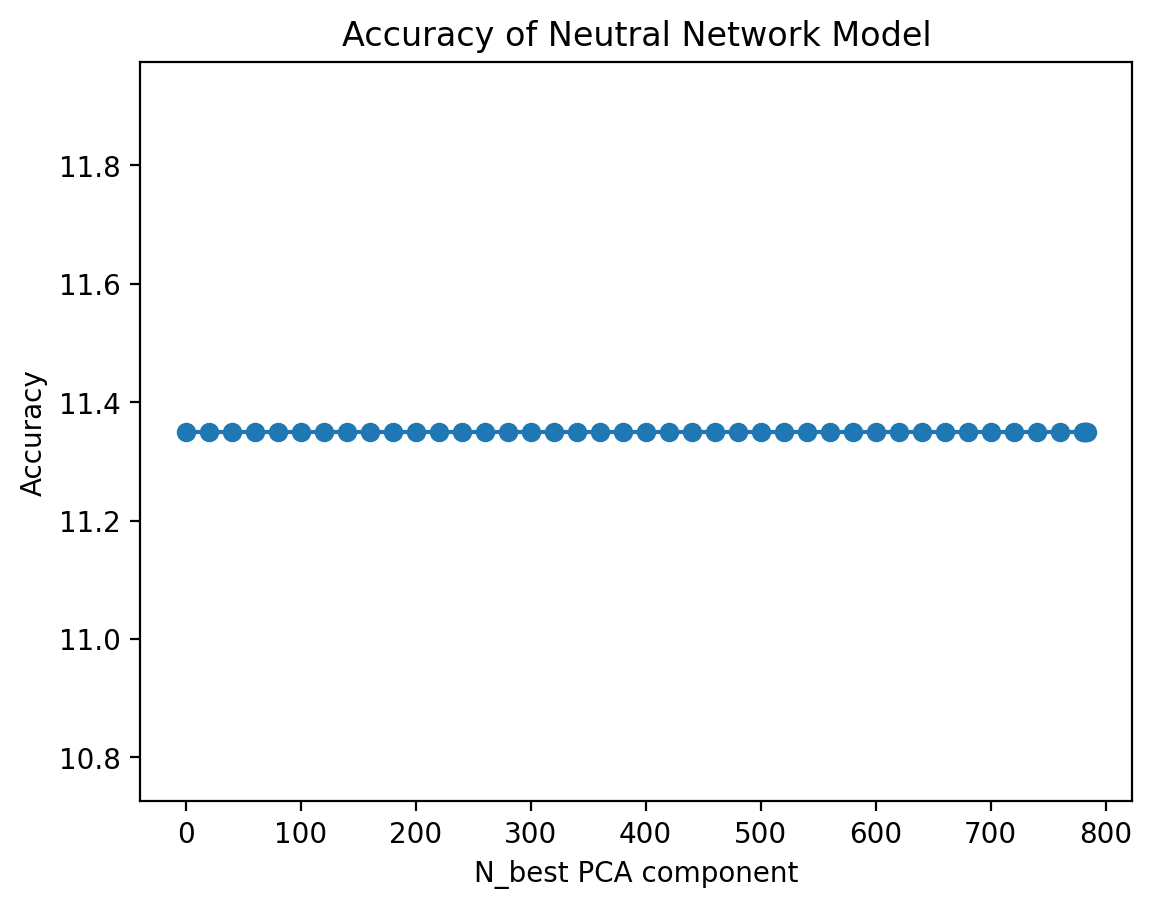

In [102]:
# the N component goes from 0 to 784
N_100=784

# Decomposing the MNIST testing dataset into PCA component
X_test_100=np.reshape(test_images,(10000,784))
mu_test_100=np.mean(X_test_100,axis=0)
x_test_100=X_test_100-mu_test_100             #ensure zero mean
rho_test_100=np.cov(x_test_100,rowvar=False)    #cavariance for the 10,000 test images
vals_test_100,vecs_test_100=linalg.eigh(rho_test_100)
P_test_100=np.dot(x_test_100,vecs_test_100)

#creating storage for accuracy corresponding to each Nth PCA component

step_100=20

N_test_accuracy_100=np.zeros(N_100)

for i in range(0,N_100,step_100):

        newImageN_100=(np.dot(P_test_100[:,0:i],vecs_test_100.T[0:i,:]))+mu_test_100

        test_data_N_100 = np.reshape(newImageN_100,[10000,28,28])
        test_loss_100,test_acc_100= model2.evaluate(test_data_N_100,test_labels,verbose=2)

        N_test_accuracy_100[i]=test_acc_100 #store accuracy

N_accuracy_100=N_test_accuracy_100[0:N:step]

# refining the edge
N_ending_100 = np.array([781,782,783,784])

N_accuracy_ending_100=np.zeros(784)

for i in N_ending_100:
    newImageN_100=(np.dot(P_test_100[:,0:i],vecs_test_100.T[0:i,:]))+mu_test_100

    test_data_N_100 = np.reshape(newImageN_100,[10000,28,28])
    test_loss_100,test_acc_100= model2.evaluate(test_data_N_100,test_labels,verbose=2)

    N_accuracy_ending_100[i-1]=test_acc_100 #store accuracy

# the accuracy near the non-reduced image
N_acc_ending_100=N_accuracy_ending_100[-4:]

#merge the accuracy
Final_N_accuracy_100 = ( np.concatenate((N_accuracy_100,N_acc_ending_100), axis=0) ) *100

#merge the N
N_x_100= np.concatenate((np.arange(0,784,20),N_ending_100),axis=0)

fig,ax=plt.subplots()
ax.plot(N_x_100,Final_N_accuracy_100,marker='o')
ax.set_xlabel('N_best PCA component')
ax.set_ylabel('Accuracy')
ax.title.set_text('Accuracy of Neutral Network Model')

## Comment
The model perform equally well across all dimensionality

## Task 5
Finally repeat steps 4 and 5 using a network trained with the best 20 components

In [ ]:
# New training dataset with 100-best PCA component

P_train=np.dot(x,vecs)       #we have already decompose the train image into PCA component in Task 1


newImage20=(np.dot(P_train[:,0:20],vecs.T[0:20,:]))+mu


# transform the dataset from (60000,784) to (60000,28,28)
new_training_dataset_20=np.flipud(np.reshape(newImage20[:,:],[60000,28,28]))


model3 = keras.Sequential([
    keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu', input_shape=(28,28,1),padding='same'),
    keras.layers.AveragePooling2D(pool_size=(3,3),padding='same'),
    keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'),
    keras.layers.AveragePooling2D(pool_size=(3,3),padding='same'),
    keras.layers.Flatten(),
    keras.layers.Dense(30,activation='relu'),
    keras.layers.Dense(10,activation='softmax')
])

model3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.SGD(lr=1.0),
              metrics=['accuracy'])
model3.summary()

history3=model3.fit(new_training_dataset_20, train_labels,batch_size=128, epochs=30)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 average_pooling2d_14 (Aver  (None, 10, 10, 32)        0         
 agePooling2D)                                                   
                                                                 
 conv2d_15 (Conv2D)          (None, 10, 10, 64)        18496     
                                                                 
 average_pooling2d_15 (Aver  (None, 4, 4, 64)          0         
 agePooling2D)                                                   
                                                                 
 flatten_7 (Flatten)         (None, 1024)              0         
                                                                 
 dense_14 (Dense)            (None, 30)               

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


469/469 [==============================] - 33s 68ms/step - loss: 2.3018 - accuracy: 0.1098
Epoch 2/30
469/469 [==============================] - 30s 63ms/step - loss: 2.3014 - accuracy: 0.1124
Epoch 3/30
469/469 [==============================] - 30s 63ms/step - loss: 2.3013 - accuracy: 0.1124
Epoch 4/30
469/469 [==============================] - 31s 66ms/step - loss: 2.3013 - accuracy: 0.1124
Epoch 5/30
469/469 [==============================] - 30s 64ms/step - loss: 2.3013 - accuracy: 0.1124
Epoch 6/30
469/469 [==============================] - 30s 65ms/step - loss: 2.3013 - accuracy: 0.1124
Epoch 7/30
469/469 [==============================] - 30s 65ms/step - loss: 2.3013 - accuracy: 0.1124
Epoch 8/30
469/469 [==============================] - 30s 64ms/step - loss: 2.3013 - accuracy: 0.1124
Epoch 9/30
469/469 [==============================] - 35s 75ms/step - loss: 2.3012 - accuracy: 0.1124
Epoch 10/30
469/469 [==============================] - 32s 67ms/step - loss: 2.3012 - accurac

In [ ]:
# the N component goes from 0 to 784 from 28x28 pixel
N_20=784

# Decomposing the MNIST testing dataset into PCA component
X_test_20=np.reshape(test_images,(10000,784))
mu_test_20=np.mean(X_test_20,axis=0)
x_test_20=X_test_20-mu_test_20             #ensure zero mean
rho_test_20=np.cov(x_test_20,rowvar=False)    #cavariance for the 10,000 test images
vals_test_20,vecs_test_20=linalg.eigh(rho_test_20)
P_test_20=np.dot(x_test_20,vecs_test_20)

#creating storage for accuracy corresponding to each Nth PCA component

step_20=20

N_test_accuracy_20=np.zeros(N_20)

for i in range(0,N_20,step_20):

        newImageN_20=(np.dot(P_test_20[:,0:i],vecs_test_20.T[0:i,:]))+mu_test_20

        test_data_N_20 = np.reshape(newImageN_20,[10000,28,28])
        test_loss_20,test_acc_20= model3.evaluate(test_data_N_20,test_labels,verbose=2)

        N_test_accuracy_20[i]=test_acc_20 #store accuracy

N_accuracy_20=N_test_accuracy_20[0:N:step]

# refining the edge
N_ending_20 = np.array([781,782,783,784])

N_accuracy_ending_20=np.zeros(784)

for i in N_ending_20:
    newImageN_20=(np.dot(P_test_20[:,0:i],vecs_test_20.T[0:i,:]))+mu_test_20

    test_data_N_20 = np.reshape(newImageN_20,[10000,28,28])
    test_loss_20,test_acc_20= model3.evaluate(test_data_N_20,test_labels,verbose=2)

    N_accuracy_ending_20[i-1]=test_acc_20 #store accuracy

# the accuracy near the non-reduced image
N_acc_ending_20=N_accuracy_ending_20[-4:]

#merge the accuracy
Final_N_accuracy_20 = ( np.concatenate((N_accuracy_20,N_acc_ending_20), axis=0) ) *100

#merge the N
N_x_20= np.concatenate((np.arange(0,784,20),N_ending_20),axis=0)

fig,ax=plt.subplots()
ax.plot(N_x_20,Final_N_accuracy_20,marker='o')
ax.set_xlabel('N_best PCA component')
ax.set_ylabel('Accuracy')
ax.title.set_text('Accuracy of Neutral Network Model')

## Comment
Both neutral network model trained with 100-best PCA and 20-best PCA perform exactly the same with an accuracy of 11.24% across all N dimensionality of the reduced test image